In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import os
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import plotly
import plotly.plotly as py
import plotly.figure_factory as ff
from plotly.graph_objs import *
import warnings

plotly_key = os.environ["PLOTLY_KEY"]
mapbox_token = "pk.eyJ1IjoiYW14bW9uZ29vc2UiLCJhIjoiY2plbG1iYml3MXdrYjJxbW80YW53dWE0bCJ9.3VkhNFfkrJISw42FzdDbRA"
plotly.tools.set_credentials_file(username='amxmongoose', api_key=plotly_key)

Data Used:
    1. U.S. census data
    2. County health data
    3. Air quality data
    
Objectives:
    1. Identify relationship between geographic information and health statistics
    2. Determine is there is a correlation between geographic air quality and health quality
    3. Show healthiest/unhealthiest places in the united states both in air quality and health statistics
    
City by region: How do they compare? Questions:

Which city/region has the best air quality? Which city/region has the best income (range or median)? Which city/region has the best health statistics? Is there a correlation between air quality and income? Is there a correlation between air quality and health? Is there a correlation between income and health?
    

In [3]:
fips_path = os.path.join('Data Sets', 'US_FIPS_Codes 2.csv')
fields = ['State', 'County Name', 'FIPS State', 'FIPS County']
fips_df = pd.read_csv(fips_path, skipinitialspace=True, usecols=fields)
fips_df = fips_df.rename(columns={'County Name':'County'})
fips_df['FIPS State'] = fips_df['FIPS State'].apply(lambda x: '{0:0>2}'.format(int(x)))
fips_df['FIPS County'] = fips_df['FIPS County'].apply(lambda x: '{0:0>3}'.format(int(x)))
fips_df["Fips"] = fips_df["FIPS State"].map(str) + fips_df["FIPS County"]

In [4]:
health_data_path = os.path.join('Data Sets', 'health_data', 'SUMMARYMEASURESOFHEALTH.csv')
fields = ['State_FIPS_Code', 'County_FIPS_Code','CHSI_County_Name','CHSI_State_Name','ALE','All_Death','Health_Status','CHSI_State_Abbr']
health_df = pd.read_csv(health_data_path, skipinitialspace=True, usecols=fields)
health_df = health_df.rename(columns={'CHSI_County_Name':'County','CHSI_State_Name':'State','CHSI_State_Abbr':'Abbr'})

In [5]:
census_data_path = os.path.join('Data Sets', 'acs2015_county_data.csv')
fields = ['State', 'County', 'TotalPop', 'Income', 'IncomePerCap', 'Poverty',
       'ChildPoverty', 'Professional', 'Service', 'Office', 'Construction',
       'Production', 'Drive', 'Carpool', 'Transit', 'Walk', 'OtherTransp',
       'WorkAtHome', 'MeanCommute', 'Employed', 'Unemployment']
census_df = pd.read_csv(census_data_path, skipinitialspace=True, usecols=fields)

In [6]:
merged_df = pd.merge(health_df,census_df,on=['County','State'],how='inner')

In [7]:
health_risk_path = os.path.join('Data Sets', 'health_data', 'RISKFACTORSANDACCESSTOCARE.csv')
fields = ['CHSI_County_Name',
          'CHSI_State_Name',
          'No_Exercise',
          'Few_Fruit_Veg',
          'Obesity',
          'High_Blood_Pres',
          'Smoker',
          'Uninsured']
health_risk_df = pd.read_csv(health_risk_path, skipinitialspace=True, usecols=fields)
health_risk_df = health_risk_df.rename(columns={'CHSI_County_Name':'County','CHSI_State_Name':'State'})

In [8]:
merged_df_2 = pd.merge(merged_df,health_risk_df,on=['County','State'],how='outer')

In [9]:
air_data_path = os.path.join('Data Sets', 'annual_aqi_by_county_2017.csv')
fields = ['State', 'County', 'Max AQI', 'Median AQI','Unhealthy Days']
air_df = pd.read_csv(air_data_path, skipinitialspace=True, usecols=fields)

In [10]:
merged_df_pop_graph = pd.merge(fips_df,census_df,on=['County','State'],how='inner')
merged_df_pop_graph = pd.merge(merged_df_pop_graph,health_df,on=['County','State'],how='outer')
merged_df_pop_graph = pd.merge(merged_df_pop_graph,air_df,on=['County','State'],how='outer')

In [11]:
merged_df = pd.merge(merged_df,air_df,on=['County','State'],how='outer')
merged_df = merged_df.dropna(subset = ['Max AQI','Median AQI','State_FIPS_Code','County_FIPS_Code'])
merged_df['County_FIPS_Code'] = merged_df['County_FIPS_Code'].apply(lambda x: '{0:0>3}'.format(int(x)))
merged_df['State_FIPS_Code'] = merged_df['State_FIPS_Code'].apply(lambda x: '{0:0>2}'.format(int(x)))
merged_df['Fips'] = merged_df['State_FIPS_Code'].map(str) + merged_df['County_FIPS_Code']

In [12]:
station_path = os.path.join('Data Sets', 'epa_air_quality_annual_summary 2.csv')
fields = ['latitude', 'longitude', 'arithmetic_mean', 'year','state_name', 'city_name', 'observation_percent','observation_count']
station_df = pd.read_csv(station_path, usecols=fields)
station_df = station_df.loc[station_df['year'] == 2015]
station_df = station_df.reset_index(drop=True)

In [13]:
latitudes = station_df['latitude']
longitudes = station_df['longitude']
text = station_df['observation_count']
total_obs = station_df['observation_count'].sum()
obs_loc = len(station_df['observation_count'])
avg_obs = total_obs/obs_loc

scl = [[0, 'rgb(150,0,90)'],
       [0.01, 'rgb(0, 0, 200)'],
       [0.05,'rgb(0, 25, 255)'],
       [0.075,'rgb(0, 152, 255)'],
       [0.1,'rgb(44, 255, 150)'],
       [0.25,'rgb(151, 255, 0)'],
       [0.5,'rgb(255, 234, 0)'],
       [1.0,'rgb(255, 111, 0)'],
       [1.5,'rgb(255, 0, 0)']];


data = Data([
    Scattermapbox(
        lat=latitudes,
        lon=longitudes,
        mode='markers',
        marker= Marker(
            color=(station_df['observation_count']/avg_obs),
            colorscale = scl,
            cmin = 0,
            cmax = 1,
            reversescale = True,
            opacity = 0.4,
            size = 10,
            showscale=True,
         ),
         text=text,
     )
 ])
      

layout = Layout(
    autosize=True,
    hovermode='closest',
    mapbox=dict(
        accesstoken=mapbox_token,
        bearing=0,
        center=dict(
            lat=39,
            lon=-98
        ),
        pitch=0,
        zoom=3,
        style='light'
    ),
)

fig = dict(data=data, layout=layout)
py.iplot(fig)

PlotlyRequestError: Hi there, you've reached the threshold of 100 combined image exports and chart saves per day. If you need to raise your daily limit, consider upgrading to a Student or Personal Plan (see: https://plot.ly/products/cloud).

In [67]:
latitudes = station_df['latitude']
longitudes = station_df['longitude']
text = station_df['observation_count']


data = Data([
    Scattermapbox(
        lat=latitudes,
        lon=longitudes,
        mode='markers',
        marker=Marker(
             size=8,
             color=station_df['observation_count'],
             colorscale= 'Viridis',
             showscale=True,
             cauto=True,
             opacity = 0.5,
         ),
         text=text,
     )
 ])

layout = Layout(
    autosize=True,
    hovermode='closest',
    mapbox=dict(
        accesstoken=mapbox_token,
        bearing=0,
        center=dict(
            lat=39,
            lon=-98
        ),
        pitch=0,
        zoom=3,
        style='light'
    ),
)

fig = dict(data=data, layout=layout)
py.iplot(fig)

In [31]:
warnings.filterwarnings('ignore')

fips = merged_df_pop_graph['Fips']

values_max = merged_df_pop_graph['TotalPop']
bins_max = [0,5000,10000,25000,50000,75000,100000,250000,500000,1000000,2500000,5000000]

fig1 = ff.create_choropleth(fips=fips, values=values_max, binning_endpoints=bins_max)

py.iplot(fig1)

The draw time for this plot will be slow for clients without much RAM.


In [27]:
fips = merged_df['Fips']

values_air = merged_df['Max AQI']
bins_air = [0,10,25,50,75,100,125,150,175,200,250,500,1000]
fig2 = ff.create_choropleth(fips=fips, values=values_air, binning_endpoints=bins_air)
py.iplot(fig2)

Text(10.05,0.5,'No Exercise Score')

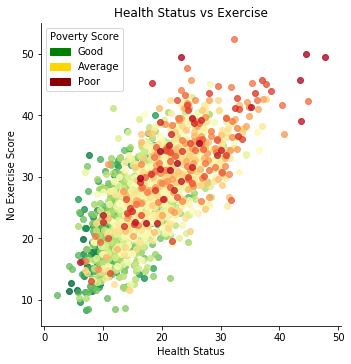

In [14]:
merged_df_reg = merged_df_2[merged_df_2['No_Exercise']>0]
merged_df_reg = merged_df_reg[merged_df_reg['Health_Status']>0]
ax = sns.lmplot(x='Health_Status',
                y='No_Exercise',
                data=merged_df_reg,
                hue='Poverty',
                palette='RdYlGn_r',
                legend=False,
                fit_reg=False
                )
plt.title('Health Status vs Exercise')
red_patch = mpatches.Patch(color='darkred', label='Poor')
yellow_patch = mpatches.Patch(color='gold', label='Average')
green_patch = mpatches.Patch(color='green', label='Good')
plt.legend(title='Poverty Score',handles=[green_patch,yellow_patch,red_patch])
plt.xlabel('Health Status',fontsize=10)
plt.ylabel('No Exercise Score',fontsize=10)

<function matplotlib.pyplot.show>

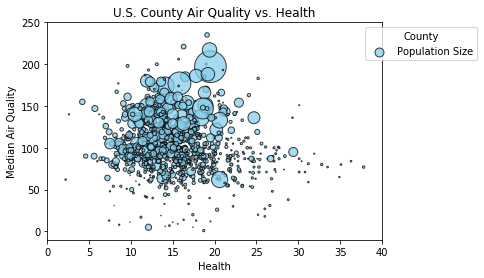

In [15]:
#Comparing US Air Quality vs Health
us_y = [merged_df['Max AQI']]

def scatter_plot_us(dfcolumn):
    return plt.scatter(x=merged_df['Health_Status'], 
            y=dfcolumn,
            edgecolors = 'black',
            color="skyblue",
            s=merged_df['TotalPop']/10000,
            marker = 'o',
            alpha=0.75,
            linewidth = 1.0)
for i in us_y:
    scatter_plot_us(i)
    
plt.legend(['Population Size'],
           title=('County'), 
           bbox_to_anchor=(1.3,1), 
           fancybox=True, 
           fontsize=10, 
           markerscale=0.4)

plt.title('U.S. County Air Quality vs. Health')
plt.xlabel('Health',fontsize=10)
plt.ylabel('Median Air Quality',fontsize=10)
plt.xlim(0,40)
plt.ylim(-10,250)
plt.show

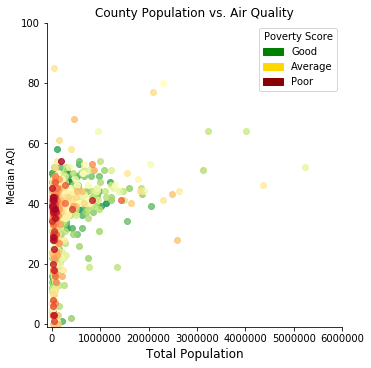

In [16]:
#City Size vs. Air quality
merged_df_city = merged_df[merged_df['Health_Status']>0]
ay = sns.lmplot(x='TotalPop',
                y='Median AQI',
                data=merged_df_city,
                hue='Health_Status',
                palette='RdYlGn_r',
                legend=False,
                fit_reg=False)
ay.set(xlim=(-100000,6000000))
ay.set(ylim=(-1,100))
plt.xlabel('Total Population',fontsize=12)
plt.title('County Population vs. Air Quality')
plt.legend(title='Poverty Score',handles=[green_patch,yellow_patch,red_patch])

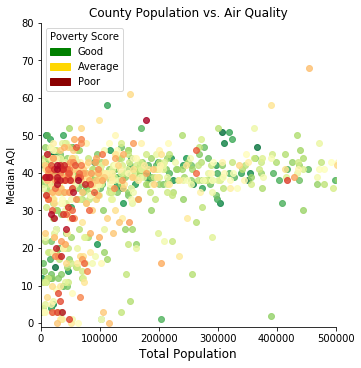

In [17]:
az = sns.lmplot(x='TotalPop',
                y='Median AQI',
                data=merged_df_city,
                hue='Health_Status',
                palette='RdYlGn_r',
                legend=False,
                fit_reg=False)
az.set(xlim=(-100,500000))
az.set(ylim=(-1,80))
plt.xlabel('Total Population',fontsize=12)
plt.title('County Population vs. Air Quality')
plt.legend(title='Poverty Score',handles=[green_patch,yellow_patch,red_patch])

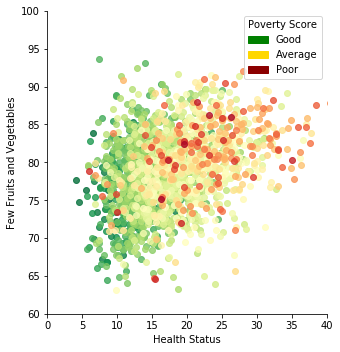

In [18]:
ab = sns.lmplot(x='Health_Status',
                y='Few_Fruit_Veg',
                data=merged_df_2,
                hue='Poverty',
                palette='RdYlGn_r',
                legend=False,
                fit_reg=False)
ab.set(xlim=(0,40))
ab.set(ylim=(60,100))
plt.xlabel('Health Status',fontsize=10)
plt.ylabel('Few Fruits and Vegetables')
plt.legend(title='Poverty Score',handles=[green_patch,yellow_patch,red_patch])

<function matplotlib.pyplot.show>

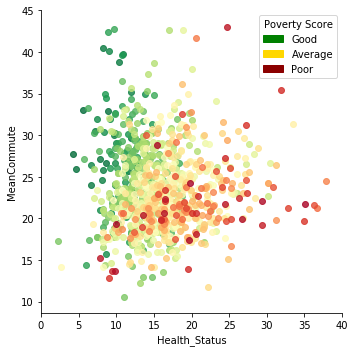

In [19]:
#Health Status vs. Mean Commute
ac = sns.lmplot(x='Health_Status',
                y='MeanCommute',
                data=merged_df,
                hue='Poverty',
                palette='RdYlGn_r',
                legend=False,
                fit_reg=False)
ac.set(xlim=(0,40))
plt.legend(title='Poverty Score',handles=[green_patch,yellow_patch,red_patch])
plt.show

(0, 40)

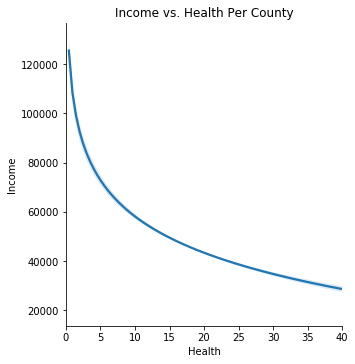

In [20]:
#Income vs Health
warnings.filterwarnings('ignore')
merged_df_reg2 = merged_df_2[merged_df_2['Income']>0]
merged_df_reg2 = merged_df_reg2[merged_df_reg2['Health_Status']>0]
ad = sns.lmplot(x='Health_Status',
                y='Income',
                data=merged_df_reg2,
                legend=False,
                logx=True,
                scatter_kws={'color':'teal','alpha':0.}
               )

plt.title('Income vs. Health Per County')
plt.xlabel('Health',fontsize=10)
plt.ylabel('Income',fontsize=10)    
plt.xlim(0,40)

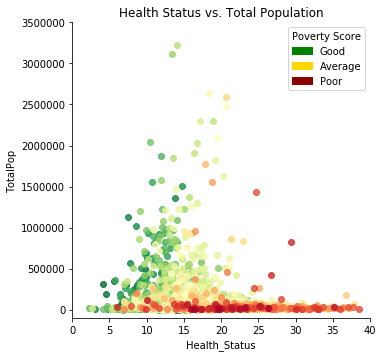

In [21]:
#Population vs Health
ae = sns.lmplot(x='Health_Status',
                y='TotalPop',
                data=merged_df_reg2,
                hue='Poverty',
                palette='RdYlGn_r',
                legend=False,
                fit_reg=False)   
plt.xlim(0,40)
plt.ylim(-100000,3500000)
plt.title('Health Status vs. Total Population')
plt.legend(title='Poverty Score',handles=[green_patch,yellow_patch,red_patch])